In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.training as cft
import claude.claudeflow.helper as cfh
import claude.claudeflow.models.SSFstatic as ssf

In [3]:
# True:  runs on cluster with GPU etc
# False: can run localy
runWithNonlinear = False

In [4]:
# Tx
param = cfs.defaultParameters(precision='double')

if runWithNonlinear:
    param.sps = 32
    param.nSamples = 4096    
    
    batch_size = 1
    runs = 10
    removeSymbols = 256
else:    
    batch_size = 2
    runs = 5
    removeSymbols = 32
    
param.M  = 16
param.Fs = param.sps * param.Rs
print(param)

M:	16
nPol:	2
sps:	16
nSamples:	1024
rollOff:	0.05
filterSpan:	128
optimizeP:	False
PdBm:	1
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
frequencyShift:	True
dispersionCompensation:	False
beta2:	2.0999953937404486e-26
dz:	1000000.0
Fs:	512000000000.0
N:	16384
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>



In [5]:
ssfParam = ssf.defaultParameters(precision='double')
ssfParam.Fs = param.Fs
ssfParam.N = param.sps * param.nSamples
ssfParam.noiseEnabled = True
ssfParam.noiseFigure = 5
ssfParam.nSpans = 10

if runWithNonlinear:
    ssfParam.gamma = 1
    ssfParam.nSteps = 1000
else:
    ssfParam.gamma = 0
    ssfParam.nSteps = 2

ssfParam.stepSize = ssfParam.spanLength/ssfParam.nSteps
ssfParam.stepSizeTemplate = ssfParam.stepSize * np.ones((ssfParam.nSteps,)) # constant stepsize

# ssfParam.stepSizeTemplate = ssf.logStepSizes(ssfParam.spanLength, ssfParam.alpha, ssfParam.nSteps) # log stepsize

print(ssfParam)

Fs:	512000000000.0
N:	16384
nSteps:	5
stepSize:	20.0
ampScheme:	EDFA
noiseEnabled:	True
manakovEnabled:	True
dispersionCompensationEnabled:	False
checkpointInverval:	2
nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	0
nSpans:	10
spanLength:	100
noiseFigure:	5
intType:	<dtype: 'int32'>
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>
stepSizeTemplate:	[20. 20. 20. 20. 20.]



In [6]:
# Constants
c = 299792458
constellation = tx.qammod(param.M)
print('const mean power: ', np.mean(np.abs(constellation)**2))
print('const.shape: ', constellation.shape)

const mean power:  1.0
const.shape:  (1, 16)


In [7]:
def run_model(param, ssfParam):
    tf.reset_default_graph()
    
    nDims = 4 # Dimension of X
    X = tf.placeholder(tf.float32, shape=(None, param.nChannels, param.nPol, param.nSamples, param.M))
    constellation_tf = tf.constant(constellation, param.complexType)

    txSymbols = cfh.QAMencoder(X, constellation_tf, realOutput=False)

    signal = cfs.wdmTransmitter(txSymbols, param)

    ssfParam.stepSize = tf.placeholder(param.realType, shape=(ssfParam.nSpans, ssfParam.nSteps))
    signal_out = ssf.model(ssfParam, signal)

    param.dispersionCompensation = True
    param.beta2  = ssfParam.D * 1e-6 * ( c / ssfParam.Fc )**2 / ( 2 * np.pi * c )
    param.dz     = ssfParam.spanLength * 1e3 * ssfParam.nSpans
    rxSymbols = cfs.wdmReceiver(signal_out, param)
    
    # remove beginning and end of symbols    
    rxSymbols, txSymbols = cfh.truncate(removeSymbols, rxSymbols, txSymbols)

    rxSymbols = cfh.staticPhaseRotationCompensation(rxSymbols)
    rxSymbols = cfh.testPhases(constellation_tf, txSymbols, rxSymbols, nDims, param.M, nTestPhases=4)
    
    # metrics    
    reduce_axis = [0, 2, 3]
    errorrate = cfh.symbolErrorrate(constellation_tf, txSymbols, rxSymbols, nDims, param.M, reduce_axis)

    signalPower = tf.constant( 1 / param.nPol, param.realType)
    effSNR = cfh.effectiveSNR(txSymbols, rxSymbols, signalPower, reduce_axis)

    # MI
    MI = []
    for (txChannel, rxChannel) in zip(tf.split(txSymbols, param.nChannels, axis=1), tf.split(rxSymbols, param.nChannels, axis=1)):
        MI_temp = cfh.gaussianMI(tf.reshape(txChannel,[-1]), tf.reshape(rxChannel,[-1]), constellation, param.M)
        MI.append(MI_temp)

    MI = tf.stack(MI)

    # only mid channel
    midChannel = param.nChannels//2 +1
    errorrate = errorrate[midChannel]
    MI = MI[midChannel]
    effSNR = effSNR[midChannel]
    
    metricsDict = {'errorrate':errorrate, 'MI': MI, 'effSNR': effSNR}    
    meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)
    
    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    sess.run(resetOps)
    for mcRun in range(runs):
        print(mcRun, end=' ', flush=True)
        randomisedStepSize = ssf.randomizeSteps(ssfParam.stepSizeTemplate, ssfParam.spanLength, ssfParam.nSpans)
        x, idx, x_seed = cu.hotOnes((batch_size, param.nChannels, param.nPol, param.nSamples),(1,2,3,4,0),param.M)
        feedDict = { X:x, ssfParam.stepSize:randomisedStepSize }
        sess.run(updateOps, feed_dict=feedDict)
    
    outMetrics = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)
    outMetrics = { key:val for key,val in zip(list(meanMetricOpsDict.keys()), outMetrics) }
    
    outString = ''
    for key, value in outMetrics.items():
        outString += ' - {}: {:.4f}'.format(key, value)
    print(outString, flush=True)

    sess.close()
    print(' ')
    return outMetrics['errorrate'], outMetrics['MI'], outMetrics['effSNR']

In [8]:
powerSweep = np.arange(-8, 2+1, 2)
SSFeffSNR = np.zeros(powerSweep.shape)

for ii, PdBm in enumerate(powerSweep):
    print('PdBm: {}'.format(PdBm), end=' - ')
    param.PdBm = PdBm
    (avErrorrate, avMI, avEffSNR) = run_model(param, ssfParam)
    SSFeffSNR[ii] = avEffSNR

PdBm: -8 - nSpans: 10, nSteps: 5


W0907 10:23:19.534480 140614151440192 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



0 1 2 3 4  - errorrate: 0.0428 - MI: 3.8304 - effSNR: 10.9699
 
PdBm: -6 - nSpans: 10, nSteps: 5
0 1 2 3 4  - errorrate: 0.0069 - MI: 3.9704 - effSNR: 12.9500
 
PdBm: -4 - nSpans: 10, nSteps: 5
0 1 2 3 4  - errorrate: 0.0009 - MI: 3.9967 - effSNR: 14.8825
 
PdBm: -2 - nSpans: 10, nSteps: 5
0 1 2 3 4  - errorrate: 0.0000 - MI: 3.9999 - effSNR: 16.8632
 
PdBm: 0 - nSpans: 10, nSteps: 5
0 1 2 3 4  - errorrate: 0.0000 - MI: 4.0000 - effSNR: 18.7714
 
PdBm: 2 - nSpans: 10, nSteps: 5
0 1 2 3 4  - errorrate: 0.0000 - MI: 4.0000 - effSNR: 20.8248
 


In [ ]:
import claude.models.NLIN as nlin
# System parameters
qamParam = nlin.defaultParameters()
qamParam.nSpans = ssfParam.nSpans

aseNoisePower, chi, X, intraConstAdd, interConstAdd = nlin.calcConstants(qamParam)
nlinPowerSweep = np.arange(-8, 4, 0.1)

# QAM
qam_constellation = np.squeeze(tx.qammod(param.M))
qamParam.kur, qamParam.kur3 = nlin.calcKur(qam_constellation)
qamEffSNR = nlinPowerSweep - nlin.calcNLIN(qamParam, nlinPowerSweep, aseNoisePower, chi, X, intraConstAdd, interConstAdd)

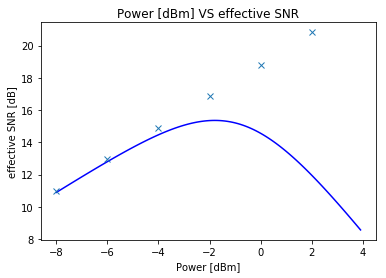

In [15]:
plt.plot(nlinPowerSweep, qamEffSNR, 'b')
plt.plot(powerSweep, SSFeffSNR, 'x')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()